## Imports

In [181]:
import copy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import torch
import torch.onnx
import torch.nn as nn
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [182]:
torch.cuda.is_available()

False

In [183]:
device = torch.device("cuda")
device

device(type='cuda')

In [184]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [185]:
def rmsle(y_true,y_pred):
    n = len(y_true)
    msle = np.mean([(np.log(max(y_pred[i],0) + 1) - np.log(y_true[i] + 1)) ** 2.0 for i in range(n)])
    return np.sqrt(msle)

In [186]:
## Data mining


In [187]:
df = pd.read_csv('data.csv')
# df[['Year', 'Month', 'Day']] = df['dteday'].str.split('-', expand=True)
df_eval_inputs = pd.read_csv('evaluation_data.csv')

In [188]:
df.shape

(10886, 17)

In [189]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [190]:
df_eval_inputs.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-20,1,0,1,0,0,4,1,1,0.26,0.2273,0.56,0.3881
1,2011-01-20,1,0,1,1,0,4,1,1,0.26,0.2727,0.56,0.0000
2,2011-01-20,1,0,1,2,0,4,1,1,0.26,0.2727,0.56,0.0000
3,2011-01-20,1,0,1,3,0,4,1,1,0.26,0.2576,0.56,0.1642
4,2011-01-20,1,0,1,4,0,4,1,1,0.26,0.2576,0.56,0.1642


In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     10886 non-null  int64  
 1   dteday      10886 non-null  object 
 2   season      10886 non-null  int64  
 3   yr          10886 non-null  int64  
 4   mnth        10886 non-null  int64  
 5   hr          10886 non-null  int64  
 6   holiday     10886 non-null  int64  
 7   weekday     10886 non-null  int64  
 8   workingday  10886 non-null  int64  
 9   weathersit  10886 non-null  int64  
 10  temp        10886 non-null  float64
 11  atemp       10886 non-null  float64
 12  hum         10886 non-null  float64
 13  windspeed   10886 non-null  float64
 14  casual      10886 non-null  int64  
 15  registered  10886 non-null  int64  
 16  cnt         10886 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 1.4+ MB


In [192]:
print(df.isna().sum())

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [193]:
fig = px.histogram(df,x='cnt')
fig.show()

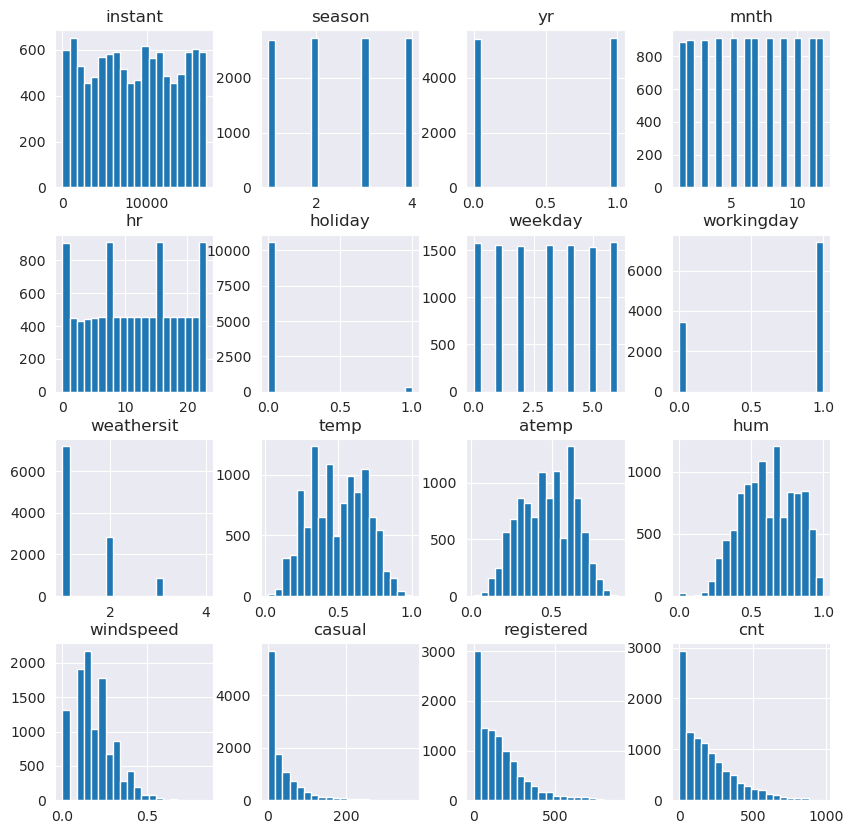

In [194]:
df.hist(bins=20, figsize=(10, 10))
plt.show()

<AxesSubplot:>

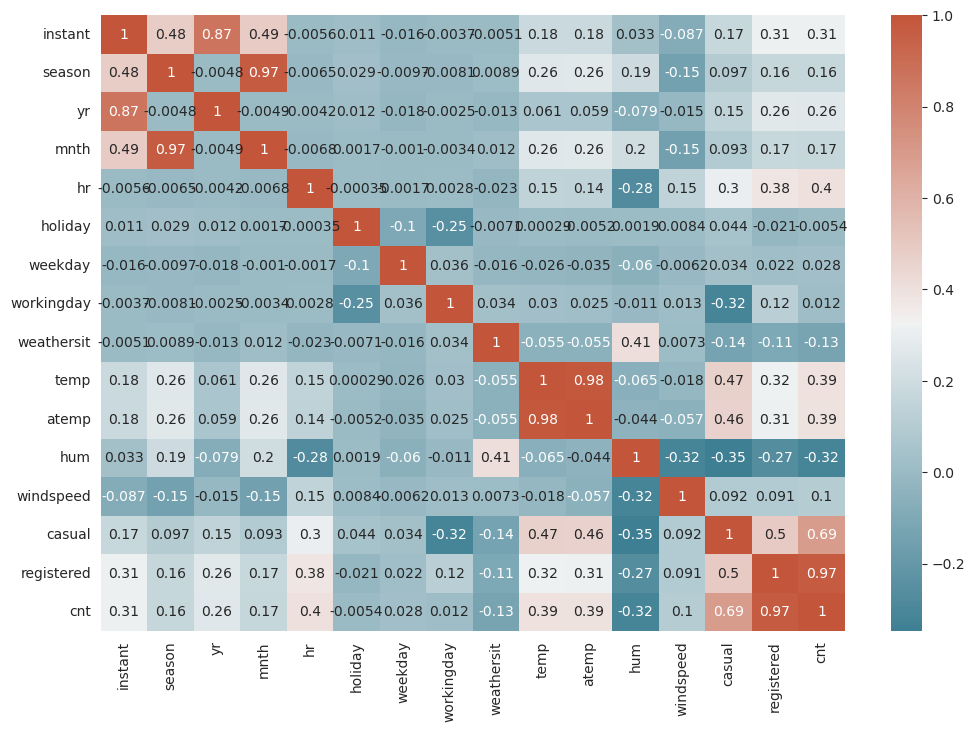

In [195]:
corr = df.corr()
plt.subplots(figsize=(12,8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [196]:
x_eval = df_eval_inputs.values[:, 1:]
x_eval

array([[1, 0, 1, ..., 0.2273, 0.56, 0.3881],
       [1, 0, 1, ..., 0.2727, 0.56, 0.0],
       [1, 0, 1, ..., 0.2727, 0.56, 0.0],
       ...,
       [1, 1, 12, ..., 0.2576, 0.6, 0.1642],
       [1, 1, 12, ..., 0.2727, 0.56, 0.1343],
       [1, 1, 12, ..., 0.2727, 0.65, 0.1343]], dtype=object)

In [197]:
x = df.values[:, 2:14]
y = df.values[:,-1]
x_norm = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, train_size=0.8, random_state=200)

train_dataset = data.TensorDataset(torch.from_numpy(x_train.astype(float)),torch.from_numpy(y_train.astype(float)))
train_data_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = data.TensorDataset(torch.from_numpy(x_test.astype(float)),torch.from_numpy(y_test.astype(float)))
test_data_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=True, drop_last=True)

data_loaders = {'train': train_data_loader, 'test':test_data_loader}

x_eval = df_eval_inputs.values[:, 1:]
evaluation_dataset = torch.from_numpy(x_eval.astype(float))

evaluation_data_loader = data.DataLoader(evaluation_dataset, batch_size=len(evaluation_dataset), shuffle=False, drop_last=False)

In [198]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden1, num_hidden2, num_hidden3, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden1)
        self.activ_func = nn.ReLU()
        self.linear2 = nn.Linear(num_hidden1, num_hidden2)
        self.linear3 = nn.Linear(num_hidden2, num_hidden3)
        self.linear4 = nn.Linear(num_hidden3, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activ_func(x)
        x = self.linear2(x)
        x = self.activ_func(x)
        x = self.linear3(x)
        x = self.activ_func(x)
        x = self.linear4(x)

        return x

In [200]:
def train_model(model, data_loaders, loss_module, optimizer, scheduler, num_epochs=100):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {}
    training_loss, training_acc, test_loss, test_acc = [], [], [], []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}:")
        for phase in ['train', 'test']:
            if phase =='train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corretcs = 0

            for inputs, targets in data_loaders[phase]:
                inputs = inputs.to(device)
                targets = targets.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    predictions = model(inputs.float())
                    predictions = predictions.squeeze(dim=1)
                    loss = loss_module(predictions, targets.float())

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                predictions = model.activ_func(predictions)
                predictions = torch.round(predictions)
                running_corretcs += torch.sum(predictions == targets)
            # if phase == 'train':
                 # scheduler.step()

            epoch_loss = running_loss / len(data_loaders[phase].dataset)
            epoch_acc = running_corretcs.double() / len(data_loaders[phase].dataset)
            if phase == 'train':
                training_loss.append(epoch_loss)
                training_acc.append(epoch_acc)
            else:
                test_loss.append(epoch_loss)
                test_acc.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc*100:2f} %')
    history.update({'training_loss' : training_loss, 'training_acc': training_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [201]:
model = SimpleClassifier(num_inputs=12, num_hidden1=1024, num_hidden2=512, num_hidden3=256, num_outputs=1)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_module = nn.L1Loss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=12, out_features=1024, bias=True)
  (activ_func): ReLU()
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=1, bias=True)
)

In [202]:
_, history = train_model(model, data_loaders, loss_module, optimizer, scheduler, num_epochs=100)

Epoch 0:
train Loss: 111.2194 Acc: 0.0073
test Loss: 94.3330 Acc: 0.0023
Epoch 1:
train Loss: 89.7161 Acc: 0.0060
test Loss: 82.7245 Acc: 0.0083
Epoch 2:
train Loss: 77.4353 Acc: 0.0090
test Loss: 74.9734 Acc: 0.0092
Epoch 3:
train Loss: 70.8399 Acc: 0.0098
test Loss: 67.7854 Acc: 0.0110
Epoch 4:
train Loss: 65.7450 Acc: 0.0134
test Loss: 63.9527 Acc: 0.0161
Epoch 5:
train Loss: 62.0491 Acc: 0.0181
test Loss: 59.5014 Acc: 0.0230
Epoch 6:
train Loss: 58.3333 Acc: 0.0225
test Loss: 58.1962 Acc: 0.0234
Epoch 7:
train Loss: 55.5178 Acc: 0.0280
test Loss: 54.7574 Acc: 0.0193
Epoch 8:
train Loss: 54.0015 Acc: 0.0257
test Loss: 53.9019 Acc: 0.0257
Epoch 9:
train Loss: 50.8266 Acc: 0.0247
test Loss: 49.7431 Acc: 0.0289
Epoch 10:
train Loss: 48.7135 Acc: 0.0254
test Loss: 49.1610 Acc: 0.0253
Epoch 11:
train Loss: 46.4827 Acc: 0.0274
test Loss: 47.0357 Acc: 0.0303
Epoch 12:
train Loss: 44.0139 Acc: 0.0272
test Loss: 44.1790 Acc: 0.0179
Epoch 13:
train Loss: 41.0626 Acc: 0.0304
test Loss: 40.4345

In [203]:
def run_rmsle():
    with torch.no_grad():
        test_data_loader = data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, drop_last=True)
        inputs, targets = next(iter(test_data_loader))
        preds = model(inputs.float())
        preds = preds.squeeze(dim=1)
        print(preds)
        rmsle_loss = rmsle(targets, preds)
        print(f"rmsle of the model: {rmsle_loss:1.3f}")
run_rmsle()

tensor([  3.9687, 187.9099,  14.8145,  ..., 321.4538, 420.7790,   4.5717])
rmsle of the model: 0.305


In [210]:
def run_eval():
    with torch.no_grad():
        inputs = next(iter(evaluation_data_loader))
        predictions = model(inputs.float())
        predictions = predictions.squeeze(dim=1)
        pd.DataFrame(predictions).to_csv("predykcje.csv", index=False, header=None)
run_eval()

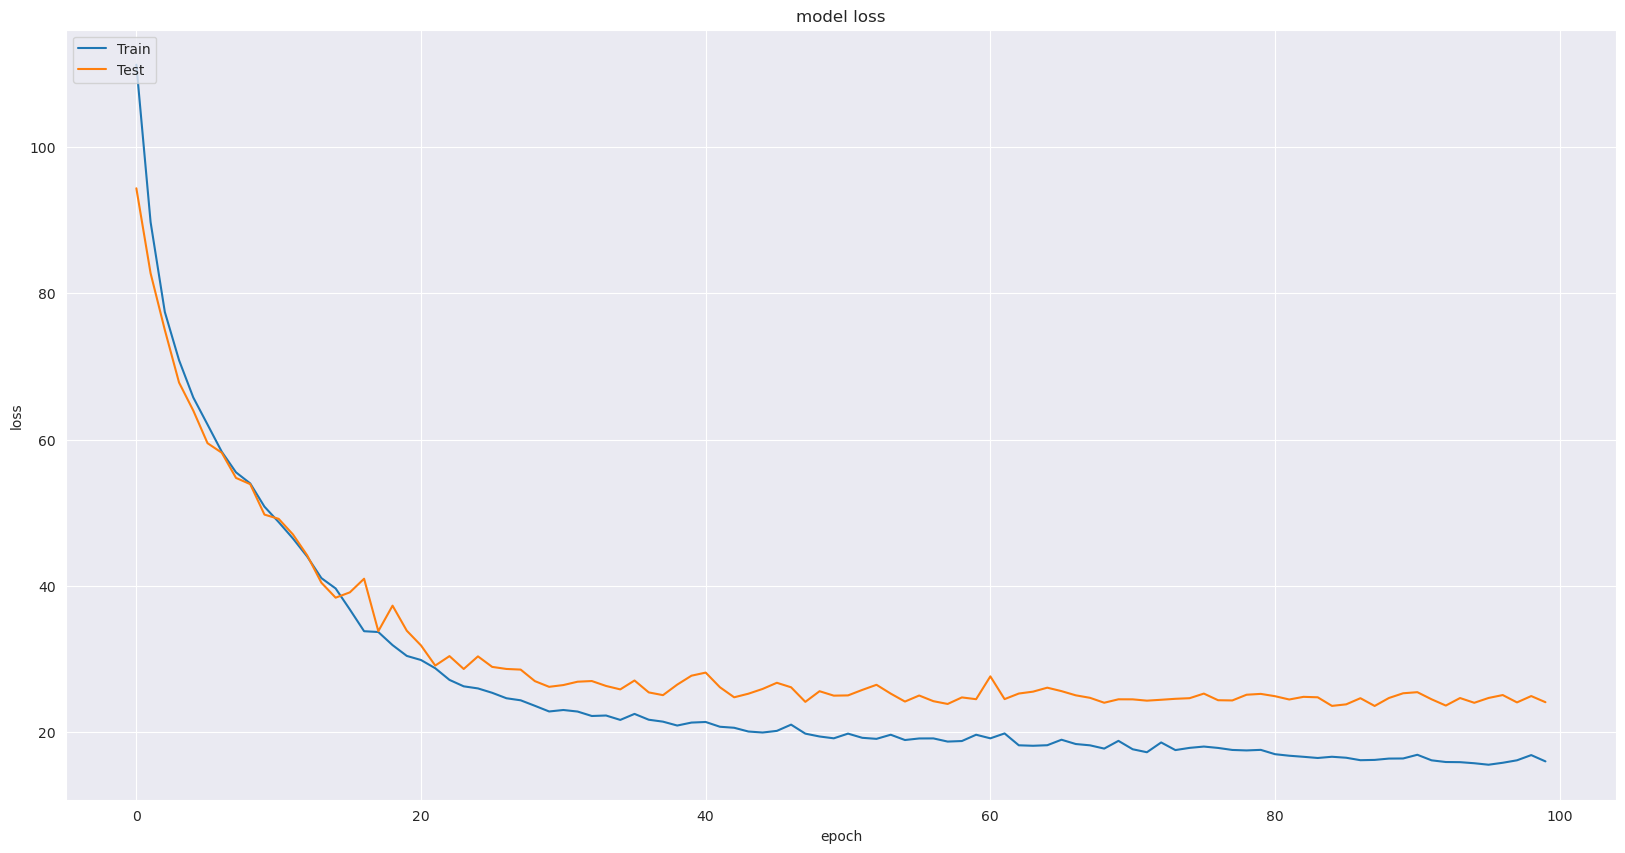

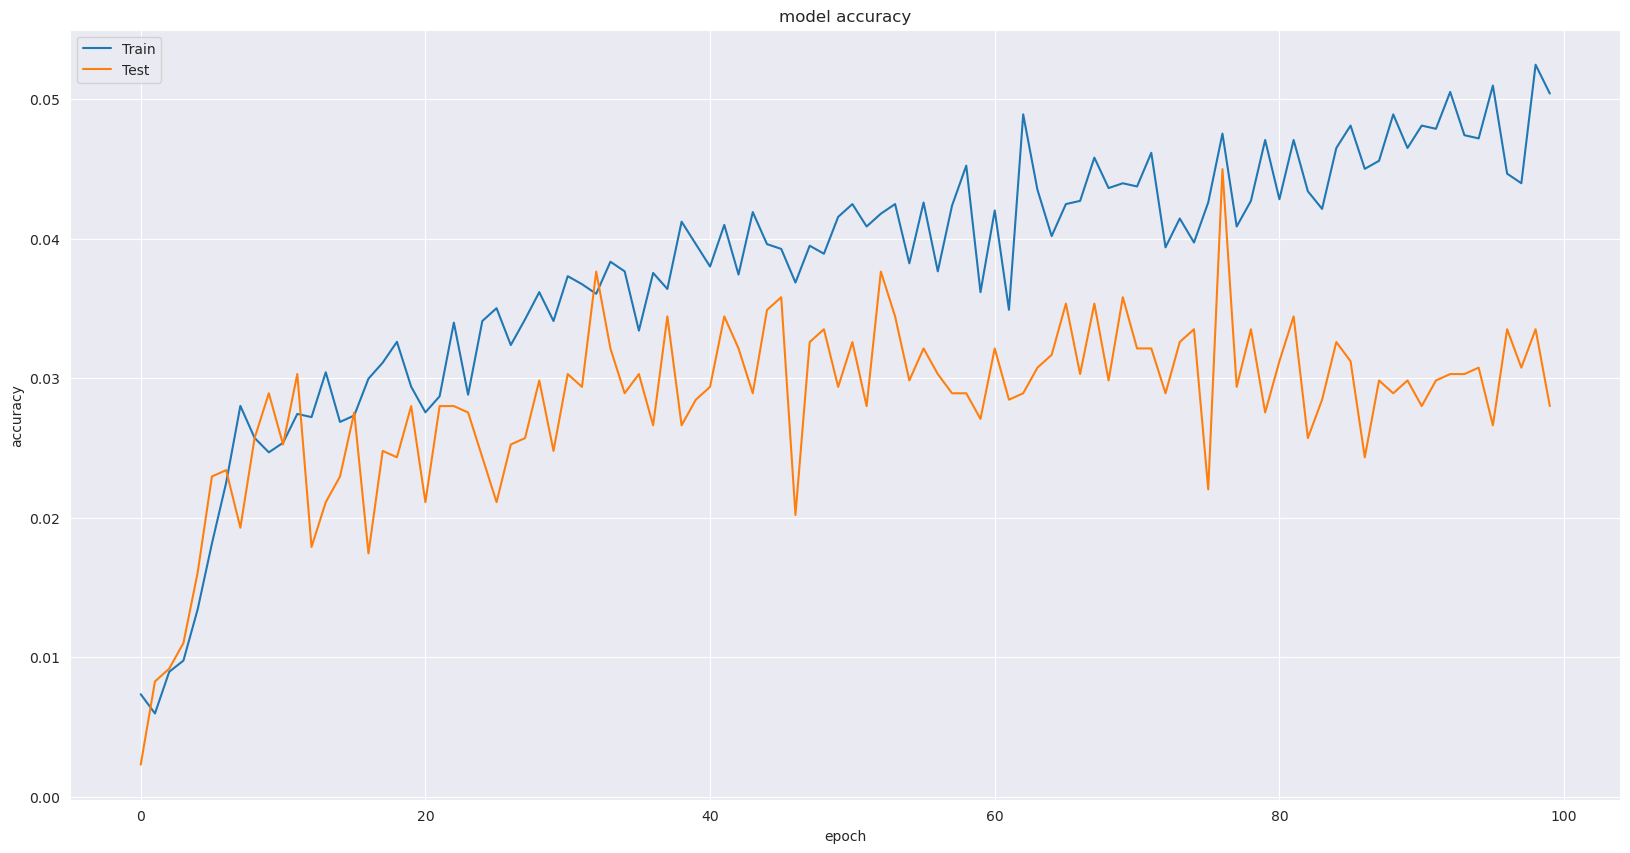

In [207]:
def my_plot(history):
    plt.figure(figsize=(20, 10))
    # plt.style.use("seaborn-paper")
    # summarize history for loss
    plt.plot(np.arange(len(history['training_loss'])),history['training_loss'])
    plt.plot(np.arange(len(history['training_loss'])),history['test_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
     # summarize history for accuracy
    plt.figure(figsize=(20, 10))
    plt.plot(np.arange(len(history['training_loss'])),history['training_acc'])
    plt.plot(np.arange(len(history['training_loss'])),history['test_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

my_plot(history)